Computational Photography, ELEC 549, Fall 2023, Rice University,

Instructor: Ashok Veeraraghavan,

Authors: Sean Farrell, Aniket Dashpute

# HW 1 - Part 3: Lucky Imaging for Astrophotography

This part deals with denoising images that have been degraded by turbulence and photon noise, the most prominent case being astronomical imaging. In this task, we after importing the dataset, we first rate the stack of images, then register and add them, and finally deblur them using a deconvolution filter.

In [3]:
# mount drive
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# move to ashok hw directory
%cd drive/MyDrive/Ashok_Hw1_Part3_Data

/content/drive/MyDrive/Ashok_Hw1_Part3_Data


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, restoration

from scipy import signal
from scipy import ndimage
from scipy.fftpack import dct, idct

from skimage.transform import warp

from tqdm import tqdm
import numpy.fft as fft

# # Import necessary packages
# import numpy as np
import os
import cv2
import sys
# from scipy.fftpack import dct, idct
# from scipy import ndimage
# from scipy.signal import fftconvolve
# import matplotlib.pyplot as plt
import pywt
import copy

**Note:**
1. Make sure the required data is loaded into the workspace.
2. Remember to first make your own copy of this notebook, if you make changes here directly, they might not be saved
----

Helpfer functions

In [6]:
VISUALIZE = True

def imshow(img, strTitle="", cbar=False):
    if not VISUALIZE:
        return
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(strTitle)
    if cbar:
        plt.colorbar()

def subplots(*args):
    '''
    example:
    subplots([img1, "title1"], [img2, "title2"], ...)
    or
    subplots(img1, img2, ...)
    '''
    if not VISUALIZE:
        return
    fig, axes = plt.subplots(1, len(args), sharey=True)
    for i, x in enumerate(args):
        try:
            img = x[0]
            strTitle = x[1]+""
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(strTitle)
        except:
            axes[i].imshow(x)
    plt.show()

def normalize(x):
    return (x-np.min(x))/(np.max(x) - np.min(x))

def dct2D(x):
    '''
    Implements 2D discrete cosine transform (DCT)
    '''
    return dct(dct(x,axis=0,norm='ortho'),axis=1,norm='ortho')

def idct2D(x):
    '''
    Implements 2D inverse discrete cosine transform (IDCT)
    '''
    return idct(idct(x,axis=0, norm='ortho'),axis=1,norm='ortho')

def fft2d(x):
    FT = fft.fftshift(fft.fft2(fft.ifftshift(x)))
    return FT

def ifft2d(x):
    IFT = fft.ifftshift(fft.ifft2(fft.fftshift(x)))
    return IFT

def imshowFT(x):
    plt.figure()
    plt.imshow(np.log(np.abs(x)+1))
    plt.colorbar()

In [7]:
def normalize_2D(x):
  '''
  This function normalizes a 2D image between 0 and 1
  '''
  return (x-np.min(x))/(np.max(x)-np.min(x))

def psnr(ref,x):
  '''
  This function computes the peak-signal-to-noise-ratio
  between two images in decibles (dB).
  '''
  if ref.size != x.size:
    print('ERROR: two images should be the same size to compute psnr.\n')
    sys.exit()
  ref = ref.astype(np.float64)
  x = x.astype(np.float64)
  RMSE = np.sqrt(np.sum((ref-x)**2)/ref.size)

  return 20*np.log10(np.max(ref)/RMSE)

Image stack shape:  (960, 1280, 101)


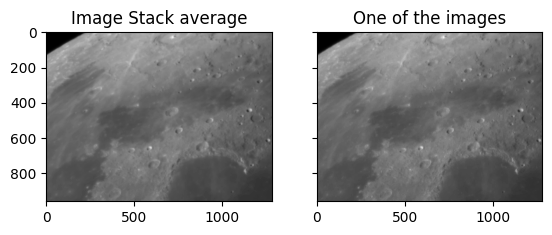

In [8]:
image_stack_moon = np.load("moon_astro_turb_stack.npy")
image_stack = np.mean(image_stack_moon, axis=2)

H, W, num_stack = image_stack.shape

image_stack = np.stack(image_stack)
print("Image stack shape: ", image_stack.shape)

image_stack_avg = np.mean(image_stack.astype(np.float64), axis=-1).squeeze()/255

# Compare stack average and one of the images
subplots([image_stack_avg,"Image Stack average"], [image_stack[:,:,0].squeeze(),"One of the images"])

## A. Make a metric to rate the images (focus measure)

### Define your focus measure

In [9]:
def rateImage(img):
    '''
    TODO:
    Implement the focus measure
    to rate each captured image
    '''
    # try to use statistical fourier but for now use m5
    wavelet = 'db4'
    decomposition_level = 4
    coeffs = pywt.wavedec2(img, wavelet, level=decomposition_level)

    low_pass_band = coeffs[0]
    high_pass_bands = coeffs[1:]

    norm_low_pass = np.linalg.norm(low_pass_band)
    norm_high_pass = np.sqrt(np.sum(np.linalg.norm(i)**2 for i in high_pass_bands))

    #M5 focus measure
    img_rating = norm_high_pass / norm_low_pass

    return img_rating
    # return img_rating

ratings_all = []
for iter in range(num_stack):
    rating = rateImage(image_stack[:,:,iter].squeeze())
    ratings_all.append(rating)
ratings_all = np.array(ratings_all)

sorted_idx = np.argsort(ratings_all)[::-1]
print(ratings_all[sorted_idx])
print(sorted_idx)

<ipython-input-9-81db7cc1e490>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm_high_pass = np.sqrt(np.sum(np.linalg.norm(i)**2 for i in high_pass_bands))


[0.04028202 0.04020819 0.03979    0.03953975 0.03899451 0.03868409
 0.03864667 0.03847936 0.03838362 0.0382373  0.03818903 0.03817917
 0.03817382 0.03815192 0.03814252 0.03811521 0.0380657  0.03806534
 0.03805853 0.03799344 0.03794121 0.03791785 0.03791444 0.03787895
 0.03784173 0.03777478 0.03777329 0.0376381  0.03757524 0.03755906
 0.0375432  0.03754083 0.03752574 0.03750919 0.03746977 0.03746698
 0.03744517 0.03744413 0.03742331 0.03739329 0.03735908 0.03734449
 0.03721121 0.03717576 0.03714603 0.03712737 0.0371175  0.03711352
 0.03709663 0.03708809 0.03708147 0.03705921 0.0370204  0.03697303
 0.0369572  0.03693986 0.03693706 0.03685095 0.03685042 0.03680654
 0.03674193 0.036674   0.03665084 0.03664989 0.03663979 0.03662633
 0.03655866 0.03653897 0.03652035 0.03648719 0.03646726 0.03646233
 0.03642565 0.03631894 0.03629787 0.03616498 0.03616145 0.03612726
 0.03609369 0.03608809 0.03608561 0.03596718 0.03593362 0.03593168
 0.03592194 0.03585842 0.03576769 0.03575527 0.03571574 0.0356

## B. Image Resgistration and Stacking

### Average top N-rated images

First without registering then after registering

In [10]:
a = [2, 3]
b = [[1],[2],[3],[4],[5],[6],[7]]
# [b[i] for i in a]
c = slice(a[0], a[1]+1, 1)
b[c]

[[3], [4]]

[ 31  32  33  30  96  34  12  72  29  75  76  11  74  35  99   5  24   9
  10  77  97  48  98  73   6   4  28 100  92  27  49  36  78  93  95   8
  91   7  80  94  50  79  19  23  18  26   0  81  51  67  17  68  69  13
  22  71  25   3  21  20  70  37  60  90  66  52  53  16  54  84  38  82
  15  89  14  39   1  65  57  88   2  58  47  40  87  55  56  83  85  45
  61  64  86  41  46  59  44  42  63  62  43]
(960, 1280, 101) (960, 1280, 11)
(960, 1280) (960, 1280)


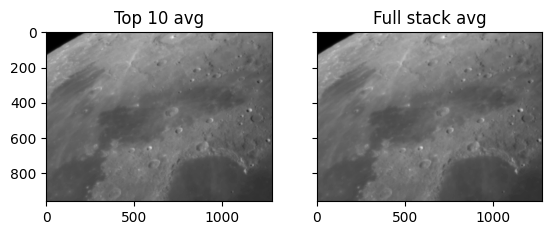

In [92]:
def avgTopN(image_stack, sorted_indices, N):
  '''
  TODO:
  Return the image obtained after
  stacking top N rated images
  '''
  print(sorted_indices)
  sorted_slice = slice(0, N+1, 1)
  imgTopN = image_stack[:, :, sorted_indices[sorted_slice]]
  print(image_stack.shape, imgTopN.shape)
  imgTopN = np.mean(imgTopN, axis=2)
  return imgTopN

def topN(image_stack, sorted_indices, N):
  '''
  TODO:
  Return the image obtained after
  stacking top N rated images
  '''
  print(sorted_indices)
  sorted_slice = slice(0, N+1, 1)
  imgTopN = image_stack[:, :, sorted_indices[sorted_slice]]
  print(image_stack.shape, imgTopN.shape)
  return imgTopN

# TODO: Play around with the value of N
N = 10
img_topN = avgTopN(image_stack, sorted_idx, N)
print(img_topN.shape, image_stack_avg.shape)

subplots([img_topN, f"Top {N} avg"], [image_stack_avg, "Full stack avg"])

### Register the images

Make use of your previous experience from HW1 - Part 2! :)

In [12]:
# def get_derivatives(A):
#   Ax = cv2.Sobel(A, cv2.CV_64F, 1, 0, ksize=3)
#   Ay = cv2.Sobel(A, cv2.CV_64F, 0, 1, ksize=3)

#   # Ax = cv2.filter2D(A, -1, kernsize)
#   # Ay = cv2.filter2D(A, -1, kernsize)
#   return Ax, Ay


def get_derivatives(A):
  kernel_x = np.array([[0, 0, 0],[0, -1.0, 1.0],[0, 0, 0]], dtype='float')
  kernel_y = np.array([[0, 0, 0],[0, -1.0, 0],[0, 1.0, 0]], dtype='float')
  Ax = cv2.filter2D(A, ddepth=-1, kernel=kernel_x)
  Ay = cv2.filter2D(A, ddepth=-1, kernel=kernel_y)
  return Ax, Ay

In [13]:
# '''
# debug version
# TODO:
# Estimate the motion to go from the frame to the reference frame
# '''
# def kl_optical_flow(ref_frame, frame, window_size):
#   # implement the matrix solution detailed in the assignment description
#   # frame is current frame, ref_frame is next frame, with all the deltas added
#   # print(frame.shape)
#   u = np.zeros(frame.shape)
#   v = np.zeros(frame.shape)
#   I_t = frame - ref_frame
#   I_x, I_y = get_derivatives(frame) # fix this to get basic kernel
#   # solve - uˆ = ((A⊤A)^−1)A⊤b
#   # shape matrix
#   for yc in range(frame.shape[0]):
#     for xc in range(frame.shape[1]):
#       # let window size be total kernel size
#       #for pix in range(-window_size//2, (window_size-1)//2):
#       min_y = max(0, yc-window_size//2)
#       min_x = max(0, xc-window_size//2)
#       max_y = min(yc+(window_size-1)//2+1, frame.shape[0])
#       max_x = min(xc+(window_size-1)//2+1, frame.shape[1])
#       # print("stats", min_y, max_y, min_x, max_x, yc-window_size//2, yc+(window_size-1)//2+1)
#       I_x_sub = I_x[min_y:max_y, min_x:max_x]
#       I_y_sub = I_y[min_y:max_y, min_x:max_x]
#       I_t_sub = I_t[min_y:max_y, min_x:max_x]
#       # print("subs", I_x_sub.shape, I_y_sub.shape, I_t_sub.shape)
#       # print("it sub", I_t_sub)
#       # print("it shape", I_t.shape)
#       A = np.vstack((I_x_sub.flatten(), I_y_sub.flatten())).T
#       b = 1*I_t_sub.flatten().T
#       # print("ycxc ashape bshape", yc, xc, A.shape, b.shape)
#       # print(A, b)
#       uhat = np.linalg.lstsq(A, b)[3]#np.linalg.inv(A.T@A)@(A.T)@b
#       # print(uhat)
#       u_temp, v_temp = uhat[0], uhat[1]
#       u[yc][xc] = u_temp
#       v[yc][xc] = v_temp
#   return u, v # per image #


'''
TODO:
Estimate the motion to go from the frame to the reference frame
'''
def kl_optical_flow(ref_frame, frame, window_size):
  # implement the matrix solution detailed in the assignment description
  # frame is current frame, ref_frame is next frame, with all the deltas added
  # print(frame.shape)
  h, w = frame.shape
  half_window = window_size//2

  u = np.zeros_like(frame)
  v = np.zeros_like(frame)

  Ix = np.gradient(frame, axis = 0)
  Iy = np.gradient(frame, axis = 1)
  It = frame - ref_frame

  # let window size be total kernel size
  # similar to ML convolutions -- start only in the middle, although we could definitely do a full convolution too.
  # another option is to just start from 0 and do min/max conditions to not go OOB, the first and last windows will be smaller but it should be
  for i in range(half_window, h - half_window):
    for j in range(half_window, w - half_window):
      Ix_sub = Ix[i-half_window:i+half_window+1,j-half_window:j+half_window+1].flatten()
      Iy_sub = Iy[i-half_window:i+half_window+1,j-half_window:j+half_window+1].flatten()
      It_sub = It[i-half_window:i+half_window+1,j-half_window:j+half_window+1].flatten()

      A = np.vstack([Ix_sub,Iy_sub]).T
      b = -It_sub.T
      optflow = np.linalg.lstsq(A,b)[0]
      u[i][j] = optflow[0]
      v[i][j] = optflow[1]
  return u, v

In [14]:
def compute_u_v(Z, ref_idx, window_size):
  [C,H,W] = Z.shape
  u_ten = np.zeros([C,H,W])
  v_ten = np.zeros([C,H,W])

  for ii in range(C):
    #print(ii)
    if ii < ref_idx:
      u,v = kl_optical_flow(Z[ii+1,:,:],Z[ii,:,:],window_size)
    elif ii > ref_idx:
      u,v = kl_optical_flow(Z[ii-1,:,:],Z[ii,:,:],window_size)
    else:
      u = np.zeros([H,W])
      v = np.zeros([H,W])

    # store the results
    u_ten[ii,:,:] = u
    v_ten[ii,:,:] = v

  return u_ten, v_ten


def warp_image_stack(Z, ref_idx, u_ten, v_ten):
  # since images are in HWC, warp it.
  # Z = np.transpose(Z, (1, 2, 0))
  [C,H,W] = Z.shape
  Z_reg = np.zeros([C,H,W]) #tensor to hold registered images

  for ii in range(C):
    #print(ii)
    # estimate the total flow from frame ii to the reference frame
    # now perform the registration - can use scikit's warp
    # store the results

    if ii < ref_idx:
      warp_u, warp_v = np.sum(u_ten[ii:ref_idx, :, :], axis=0), np.sum(u_ten[ii:ref_idx, :, :], axis=0)
    elif ii > ref_idx:
      warp_u, warp_v = np.sum(u_ten[ref_idx:ii, :, :], axis=0), np.sum(v_ten[ref_idx:ii, :, :], axis=0)
    else:
      warp_u = np.zeros([H,W])
      warp_v = np.zeros([H,W])

    row_coords, col_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    result = warp(copy.deepcopy(Z[ii]), np.array([row_coords - warp_u, col_coords - warp_v]), mode = "edge", cval = 0)
    Z_reg[ii,:,:] = result
  return Z_reg

In [15]:
import numpy as np
a = np.array([[1000,9],[2,3]])
b = np.array([300,40])
c = np.vstack((b, a))
print(c)
np.argmax(c, axis=0), np.argmax(c, axis=1)

[[ 300   40]
 [1000    9]
 [   2    3]]


(array([1, 0]), array([0, 0, 1]))

In [16]:
import numpy as np

def find_max_location(arr):
    # Find the indices of the maximum value along each axis
    y_index, x_index = np.unravel_index(np.argmax(arr), arr.shape)

    return y_index, x_index

# Example usage:
arr = np.array([[1, 2, 3], [4, 5, 6000], [70, 8, 9]])
y, x = find_max_location(arr)
print("Max Value Location (x, y):", x, y)


Max Value Location (x, y): 2 1


In [99]:
def registerImage(imgRef1, img2):
  '''
  TODO:
  Implement image registration code,
  you could use your Part 2 code here
  '''
  # if we are only registering 2 images, we can set Z as [img1, img2] and ref_idx as ind of img2
  ref = 0 # ref is image0
  winsize = 3
  Zstacc = np.array([imgRef1, img2])
  uten, vten = compute_u_v(Zstacc, ref, winsize)
  registered_img2 = np.mean(warp_image_stack(Zstacc, ref, uten, vten), axis=0)
  print(Zstacc.shape, registered_img2.shape)
  return registered_img2

def registerStack(imgRef1, stacc, mean=True):
  '''
  TODO:
  Implement image registration code,
  you could use your Part 2 code here
  '''
  # if we are only registering 2 images, we can set Z as [img1, img2] and ref_idx as ind of img2
  ref = 0 # ref is image0
  winsize = 3
  Zstacc = np.dstack((imgRef1, stacc))
  # warp to CHW
  Zstacc = np.transpose(Zstacc, (2, 0, 1))
  uten, vten = compute_u_v(Zstacc, ref, winsize)
  registered_img2 = warp_image_stack(Zstacc, ref, uten, vten)
  if mean:
    registered_img2 = np.mean(registered_img2, axis=0)
  #print(Zstacc.shape, registered_img2.shape)
  return registered_img2

(960, 1280) (960, 1280, 101)


<ipython-input-13-be43ffd09b78>:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  optflow = np.linalg.lstsq(A,b)[0]


(2, 960, 1280) (960, 1280)
[ 31  32  33  30  96  34  12  72  29  75  76  11  74  35  99   5  24   9
  10  77  97  48  98  73   6   4  28 100  92  27  49  36  78  93  95   8
  91   7  80  94  50  79  19  23  18  26   0  81  51  67  17  68  69  13
  22  71  25   3  21  20  70  37  60  90  66  52  53  16  54  84  38  82
  15  89  14  39   1  65  57  88   2  58  47  40  87  55  56  83  85  45
  61  64  86  41  46  59  44  42  63  62  43]
(960, 1280, 101) (960, 1280, 11)


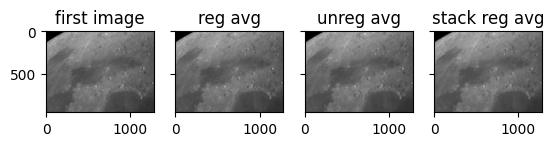

In [101]:


image0 = image_stack[...,sorted_idx[0]].squeeze()/255  # Reference image.
image1 = image_stack[...,sorted_idx[1]].squeeze()/255  # Image to be aligned.
images = image_stack.squeeze()/255
print(image0.shape, images.shape)
avg_img = (image0+image1)/2

reg_avg = registerImage(image0, image1)
topN_images = topN(images, sorted_idx, N)
reg_stack = registerStack(image0, topN_images, mean=False)
reg_stack_avg = np.mean(reg_stack, axis=0)

# could also pick top images and run registerStack

subplots([image0, "first image"], [reg_avg, "reg avg"], [avg_img, "unreg avg"], [reg_stack_avg, "stack reg avg"])

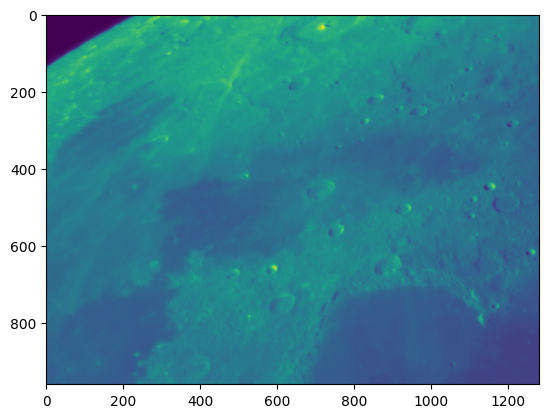

In [102]:
plt.imshow(reg_stack[0])

In [93]:
topN_images = topN(images, sorted_idx, N)

[ 31  32  33  30  96  34  12  72  29  75  76  11  74  35  99   5  24   9
  10  77  97  48  98  73   6   4  28 100  92  27  49  36  78  93  95   8
  91   7  80  94  50  79  19  23  18  26   0  81  51  67  17  68  69  13
  22  71  25   3  21  20  70  37  60  90  66  52  53  16  54  84  38  82
  15  89  14  39   1  65  57  88   2  58  47  40  87  55  56  83  85  45
  61  64  86  41  46  59  44  42  63  62  43]
(960, 1280, 101) (960, 1280, 11)


0.040282015981963334


<ipython-input-9-81db7cc1e490>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm_high_pass = np.sqrt(np.sum(np.linalg.norm(i)**2 for i in high_pass_bands))


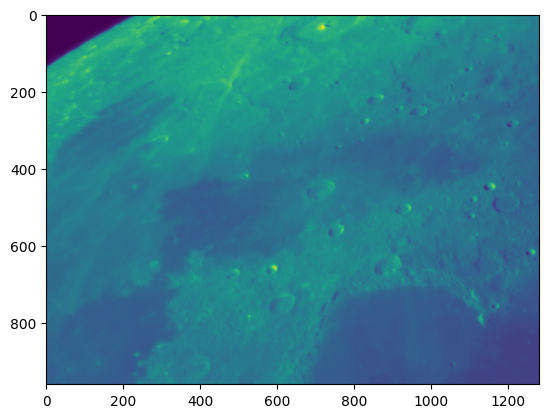

In [95]:
print(rateImage(topN_images[:,:,0]))
plt.imshow(topN_images[:,:,0])

0.040208194789350796


<ipython-input-9-81db7cc1e490>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm_high_pass = np.sqrt(np.sum(np.linalg.norm(i)**2 for i in high_pass_bands))


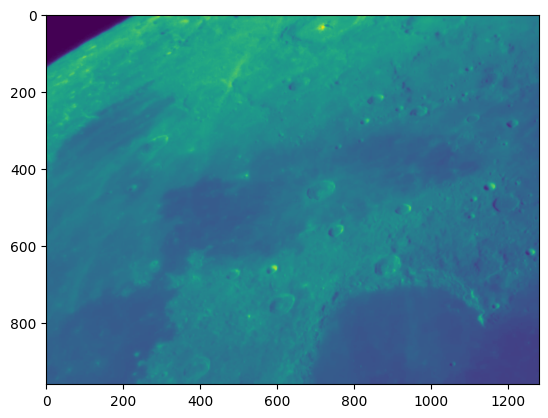

In [96]:
print(rateImage(topN_images[:,:,1]))
plt.imshow(topN_images[:,:,1])

0.039789997353508036


<ipython-input-9-81db7cc1e490>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm_high_pass = np.sqrt(np.sum(np.linalg.norm(i)**2 for i in high_pass_bands))


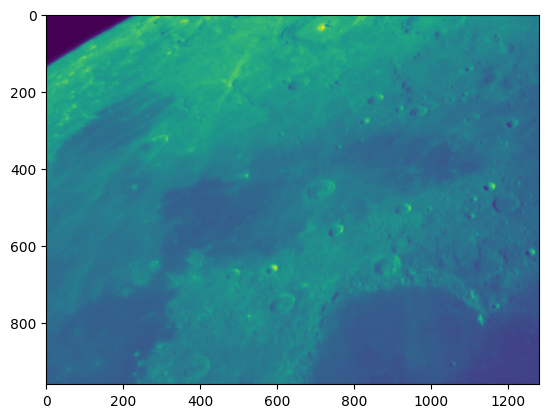

In [97]:
print(rateImage(topN_images[:,:,2]))
plt.imshow(topN_images[:,:,2])

In [23]:
print(psnr(normalize_2D(image0), normalize_2D(reg_avg)))
print(psnr(normalize_2D(image0), normalize_2D(avg_img)))
print(np.max(np.abs(reg_avg-avg_img)))

50.64154206368659
50.64154206368659
0.0


### Register and stack images

Same operations as before but this time, do the operations patch-wise instead of on the whole image at once. For a patch of the image, get the top-N rated images, register and average them to get a "good" patch.

Note: The patch-wise operation can be slow, so don't worry if it takes few minutes

In [24]:


def extract_patches(image, patch_size):
    """
    Divide an image into a list of patches with the specified patch size.
    If the image is not evenly divisible into patches, smaller edge patches will be included.

    Args:
        image (numpy.ndarray): The input image.
        patch_size (tuple): The size of each patch in the format (width, height).

    Returns:
        List of patches (list of numpy.ndarray).
    """
    patches = []
    image_height, image_width = image.shape
    patch_height, patch_width = patch_size

    num_rows = image_height // patch_height
    num_cols = image_width // patch_width

    for row in range(num_rows):
        for col in range(num_cols):
            x = col * patch_width
            y = row * patch_height
            patch = image[y:y + patch_height, x:x + patch_width]
            patches.append(patch)

    if image_height % patch_height != 0:
        for col in range(num_cols):
            x = col * patch_width
            patch = image[image_height - patch_height:, x:x + patch_width]
            patches.append(patch)

    if image_width % patch_width != 0:
        for row in range(num_rows):
            y = row * patch_height
            patch = image[y:y + patch_height, image_width - patch_width:]
            patches.append(patch)

    if image_height % patch_height != 0 and image_width % patch_width != 0:
        patch = image[image_height - patch_height:, image_width - patch_width:]
        patches.append(patch)

    return patches


# def reconstruct_image(sorted_patchlists, sorted_indices, patch_size, image_size):
#     """
#     Reconstruct an image from sorted patches and their corresponding positions.

#     Args:
#         sorted_patchlists (numpy.ndarray): Array of sorted patches with shape (n_images, n_patches/img, height, width).
#         sorted_indices (numpy.ndarray): Array of sorted indices for each patch.
#         patch_size (tuple): Size of each patch in the format (width, height).
#         image_size (tuple): Size of the output image in the format (width, height).

#     Returns:
#         Reconstructed image (numpy.ndarray).
#     """
#     num_images, num_patches, patch_height, patch_width = sorted_patchlists.shape
#     image_width, image_height = image_size
#     patch_width, patch_height = patch_size

#     # Initialize an empty image
#     reconstructed_image = np.zeros((image_height, image_width, 3), dtype=np.uint8)

#     # Iterate through the patches and place them in the image at their respective positions
#     for i in range(num_images):
#         for j in range(num_patches):
#             patch = sorted_patchlists[i, j]
#             index = sorted_indices[i, j]
#             col = index % (image_width // patch_width)
#             row = index // (image_width // patch_width)
#             x = col * patch_width
#             y = row * patch_height
#             reconstructed_image[y:y + patch_height, x:x + patch_width] = patch

#     return reconstructed_image

def reconstruct_image_from_patches(patches, patch_size, image_size):
    """
    Reconstruct an image from a list of patches.

    Args:
        patches (list of numpy.ndarray): List of patches to be reconstructed.
        image_size (tuple): Size of the output image in the format (width, height).
        patch_size (tuple): Size of each patch in the format (width, height).

    Returns:
        Reconstructed image (numpy.ndarray).
    """
    image_height, image_width = image_size
    patch_height, patch_width = patch_size

    # Calculate the number of rows and columns in the reconstructed image
    num_cols = image_width // patch_width
    num_rows = image_height // patch_height

    # Initialize an empty image to reconstruct into
    reconstructed_image = np.zeros((image_height, image_width), dtype=patches[0].dtype)

    patch_index = 0

    for row in range(num_rows):
        for col in range(num_cols):
            x = col * patch_width
            y = row * patch_height
            #print(x, y, patch_index)
            reconstructed_image[y:y + patch_height, x:x + patch_width] = patches[patch_index]
            patch_index += 1

    return reconstructed_image


In [25]:
def stack_and_register(img_stack_full, patch_size, topN=20):
  '''
  TODO:
  Break the image into patches,
  perform the previous operations patch-wise this time
  Pseudo code:
  # for each patch in the image:
    # rate the image patches (same area, different images in stack,
    # essentially rating 'patch' stacks) and sort them
    # register top N images with respect to a reference and
    # average out those to get best patch
  '''
  patchlists = []
  patch_indices = []
  # break images into patches
  for img_i in range(img_stack_full.shape[2]):
    patchlists.append(extract_patches(img_stack_full[:,:,img_i], patch_size))
    patch_indices.append(img_i)
  patchlists = np.array(patchlists) # will have indices (n_images, n_patches/img, y, x)

  # for each patch stack, pick top N rated ones
  # compute metric then use np argsort
  patchlists = np.transpose(patchlists, (1, 0, 2, 3))
  n_patches_per_img, n_images, height, width = patchlists.shape

  # Compute metrics for each patch
  patch_metrics = np.zeros((n_patches_per_img, n_images))
  for i in range(n_patches_per_img):
      for j in range(n_images):
          patch_metrics[i, j] = rateImage(patchlists[i, j])

  # Sort the indices based on patch metrics
  sorted_indices = np.argsort(patch_metrics, axis=1) # sort by the image from which the patch comes

  # Initialize a new array to store the sorted patches
  chosen_patches = np.zeros((n_patches_per_img, height, width))

  # Iterate through the patches and pick the best images for each one
  for i in range(n_patches_per_img):
      # sort and register
      #print(i, patchlists[i].shape, patchlists[i, sorted_indices[i][0]].shape, patchlists[i, sorted_indices[i][:topN+1]].shape)
      # input is HWC, output is CHW
      temp_regimg = registerStack(patchlists[i, sorted_indices[i][0]], np.transpose(patchlists[i, sorted_indices[i][:topN+1]], (1,2,0)))
      #print(temp_regimg.shape)
      chosen_patches[i] = temp_regimg # already ordered
  # run registerStack on each stack of patches
  # patchlists is in shape (n_patches_per_img, n_images, y, x)
  # print((patch_size, patch_size), img_stack_full.shape)
  img_patch_registered = reconstruct_image_from_patches(chosen_patches, patch_size, (960, 1280))

  return img_patch_registered, chosen_patches

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
<ipython-input-9-81db7cc1e490>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm_high_pass = np.sqrt(np.sum(np.linalg.norm(i)**2 for i in high_pass_bands))
<ipython-input-13-be43ffd09b78>:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  optflow = np.linalg.lstsq(A,b)[0]


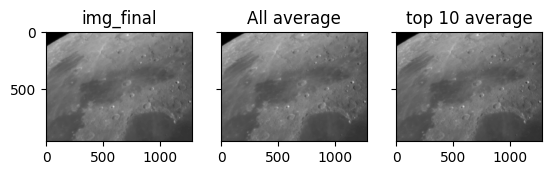

In [103]:
patch_size = [20, 20]
N = 10
image_stack_gray = np.mean(image_stack, axis=2).squeeze()
img_out1, chosen_patches = stack_and_register(image_stack[:,:,:], patch_size, N)

subplots([img_out1, "img_final"], [image_stack_avg/255, "All average"], [img_topN/255, f"top {N} average"])

## C. PSF estimation and Deconvolution

4911.000000000001 32 717
4962.666666666667 33 717
4973.666666666667 35 716
4930.333333333334 33 718
5057.333333333334 33 719
5027.666666666667 34 718
4900.0 32 718
4951.666666666667 34 717
4941.666666666667 34 717
5041.999999999999 32 718
5099.333333333333 32 718
5094.666666666667 32 718
5076.000000000001 33 718
5038.333333333334 34 717
5064.333333333334 34 718
5031.333333333334 35 718
5031.0 33 719
4988.0 35 719
5050.0 36 718
5069.333333333333 36 719
4921.333333333334 35 719
4969.0 35 720
5020.666666666666 34 719
5076.666666666667 34 719
5012.0 34 719
4997.333333333333 34 719
5074.0 34 718
5012.333333333334 33 718
5062.666666666667 33 718
5037.333333333333 33 718
5047.666666666667 32 718
5064.999999999999 34 717
5101.666666666666 33 719
5045.0 33 719
5023.666666666667 35 719
4974.333333333333 34 717
4954.999999999999 33 718
5040.333333333333 32 719
5059.0 32 719
5020.0 33 718
5004.666666666666 33 718
4983.666666666666 32 720
5040.666666666666 32 719
4928.333333333333 31 719
4995.66666

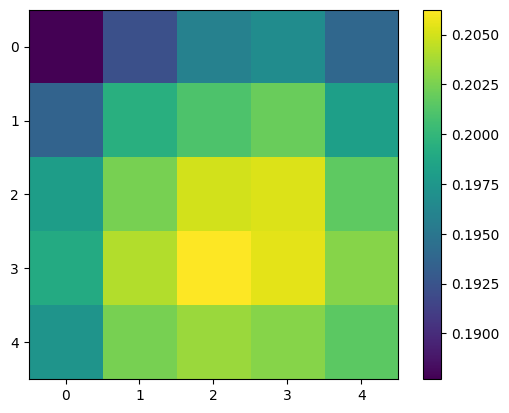

In [109]:
def choosePSF(image_stack, psf_size):
  '''
  HWC
  TODO: # center is determined adaptively
  Make an esimate of PSF using some point-like source
  in the image. Look at the average profile of the point
  and use that as the PSF.
  Don't forget to normalize, and then also
  make sure that np.sum(psf) = 1
  Note: If you're not able to get an esimate of PSF from
  the image, choose a filter (Gaussian or box), and play around
  with it's size to get a good deblurred image. If you choose this
  option, explain in the report why the first part didn't work.
  '''
  # adaptive psf finder by defining a glare measure
  # or a point source is nothing more than a delta in time
  # so we're finding a delta in frequency and snapping an area around it equal to what the expected average blur would be
  # find argmax delta of each image
  # set an area around the deltas
  # use the delta location of the image of the highest sum
  # size is y then x
  psf_sums = []
  argmaxes = []
  for c in range(image_stack.shape[2]):
    argmaxes.append(find_max_location(np.abs(image_stack[:,:,c])))
  for k in range(image_stack.shape[2]):
    # take the area of psf size around argmax
    y, x = argmaxes[k]
    psf_sums.append(np.sum(image_stack[y-psf_size[0]//2:y+psf_size[0]//2+1,x-psf_size[1]//2:x+psf_size[1]//2+1,k]))
    print(psf_sums[-1], y, x)
  k_max = np.argmax(np.array(psf_sums))
  top = argmaxes[k_max][0]-psf_size[0]//2
  bot = argmaxes[k_max][0]+psf_size[0]//2+1
  left = argmaxes[k_max][1]-psf_size[1]//2
  right = argmaxes[k_max][1]+psf_size[1]//2+1
  print(top, bot, left, right)

  # assume our area is [top:bot][left:right]
  # should assume we have an average image but ig not
  sliceY = slice(top, bot, 1)
  sliceX = slice(left, right, 1)
  # average the stack - y, x, d
  slice_avg = np.mean(image_stack[sliceY, sliceX, :], axis=2)
  # normalize
  psf = slice_avg / np.linalg.norm(slice_avg)
  return psf

psf = choosePSF(image_stack, (5, 5))
plt.figure()
plt.imshow(psf)
plt.colorbar()

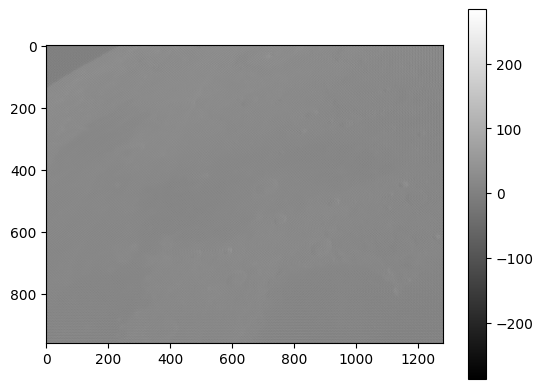

In [105]:
def DeconvAlgo(img_noisy, psf, _other_params_=None):
  '''
  Implement a deconvolution algiorithm,
  like Wiener Deconvolution, or
  Richardson Lucy, or any other algirithm of your choice
  '''
  # fast deconvolution with fft
  # pad psf
  padding = (((960-psf.shape[0])//2, (960-psf.shape[0])//2+1), ((1280-psf.shape[1])//2, (1280-psf.shape[1])//2+1))
  psf = np.pad(psf, padding, mode='constant', constant_values=0)
  # fft both noisy img and psf
  noisy_fft = fft2d(img_noisy)
  psf_fft = fft2d(psf)
  # divide, hope none are zero
  result_fft = noisy_fft / psf_fft
  # ifft
  img_deconv = np.real(ifft2d(result_fft))
  return img_deconv

img_out2 = DeconvAlgo(img_out1, psf)

plt.figure()
plt.imshow(img_out2, cmap='gray')
plt.colorbar()
# this is experimental code, wiener is better

In [110]:
def wiener_deconvolution(image, psf, signal_to_noise_ratio):

    image_fft = np.fft.fft2(image)
    psf_fft = np.fft.fft2(psf, s=image.shape)

    wiener_filter = np.conj(psf_fft) / (np.abs(psf_fft)**2 + 1 / signal_to_noise_ratio)

    deconvolved_image_fft = image_fft * wiener_filter
    deconvolved_image = np.fft.ifft2(deconvolved_image_fft).real

    return deconvolved_image

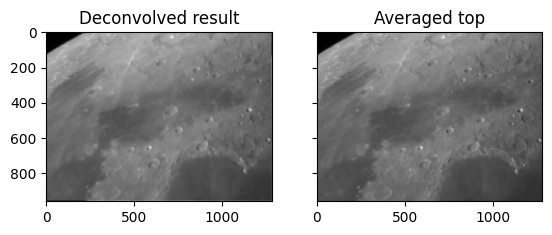

In [111]:
deconv = wiener_deconvolution(img_out1, psf, 1e-3)

subplots([deconv,"Deconvolved result"], [img_topN,"Averaged top"])

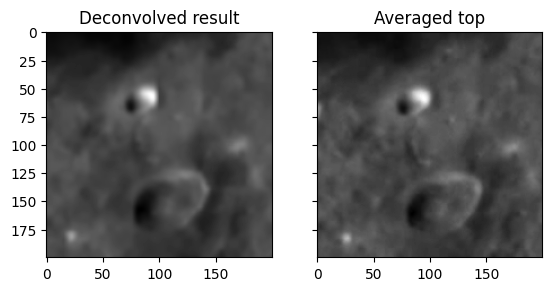

In [112]:
subplots([deconv[600:800,500:700],"Deconvolved result"], [img_topN[600:800,500:700],"Averaged top"])